# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Наивный байесовский классификатор { display-mode: "both" }
# В программе реализован наивный байесовский классификатор
#@markdown [Оригинальная программа](https://github.com/wzyonggege/statistical-learning-method/blob/master/NaiveBayes/GaussianNB.ipynb)
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
#@markdown - **Привязка данных**
class Bunch(dict):  
	def __init__(self,*args,**kwds):  
		super(Bunch,self).__init__(*args,**kwds)  
		self.__dict__ = self

In [0]:
#@markdown - **Классификатор**
class NaiveBayes:
    def __init__(self):
        self.model = None
        self.prior = None

    # Математическое ожидание
    @staticmethod
    def mean(X):
        return sum(X) / float(len(X))

    # Среднеквадратическое отклонение
    def stdev(self, X):
        avg = self.mean(X)
        return np.sqrt(sum([pow(x-avg, 2) for x in X]) / float(len(X)))

    # Плотность вероятности
    def gaussian_probability(self, x, mean, stdev):
        exponent = np.exp(-(np.power(x-mean,2)/(2*np.power(stdev,2))))
        return (1 / (np.sqrt(2*np.pi) * stdev)) * exponent

    # Обработка X_train
    def summarize(self, train_data):
        summaries = [(self.mean(i), self.stdev(i)) for i in zip(*train_data)]
        return summaries
    
    # Вычисление априорной вероятности каждой категории
    def prob_y(self, y):
        labels = list(set(y))
        num_labels = np.array([sum((y == label) << 0) for label in labels])
        return num_labels.astype('float32') / y.shape[0]
    
    # Обучение модели
    def fit(self, X, y):
        labels = list(set(y))
        data = {label:[] for label in labels}
        for f, label in zip(X, y):
            data[label].append(f)
        self.model = {label: self.summarize(value) for label, value in data.items()}
        self.prior = self.prob_y(y)
        return 'model is trained!'

    # Вычисление вероятности
    def calculate_probabilities(self, input_data):
        probabilities = {}
        prob = 0
        for label, value in self.model.items():
            probabilities[label] = 1
            for i in range(len(value)):
                mean, stdev = value[i]
                probabilities[label] *= self.gaussian_probability(input_data[i], mean, stdev)
            probabilities[label] *= self.prior[int(label)]
            prob += probabilities[label]
        return probabilities, prob
    
    # Нормализованная вероятность  
    def normalized_prob(self, input_data):
        probabilities, prob = self.calculate_probabilities(input_data)
        for label, value in probabilities.items():
            probabilities[label] = value / prob
        return probabilities

    # Прогноз категории
    def predict(self, X_test):
        label = sorted(self.calculate_probabilities(X_test)[0].items(), key=lambda x: x[-1])[-1][0]
        return label.astype("uint8")
    
    # Точность
    def score(self, X_test, y_test):
        right = 0
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right += 1
        return right / float(len(X_test))

In [0]:
#@markdown - **Генератор стохастических данных**
def generate_random(sigma, N, mu1=[15., 25., 10], mu2=[30., 40., 30], mu3=[25., 10., 20], mu4=[40., 30., 40]):  
	c = sigma.shape[-1]
	X = np.zeros((N, c))
	target = np.zeros((N,1))
	for i in range(N):  
		if np.random.random(1) < 0.25:
			X[i, :]  = np.random.multivariate_normal(mu1, sigma[0, :, :], 1)     # первая гауссовская модель  
			target[i] = 0
		elif 0.25 <= np.random.random(1) < 0.5:  
			X[i, :] = np.random.multivariate_normal(mu2, sigma[1, :, :], 1)      # вторая гауссовская модель  
			target[i] = 1
		elif 0.5 <= np.random.random(1) < 0.75:  
			X[i, :] = np.random.multivariate_normal(mu3, sigma[2, :, :], 1)      # третья гауссовская модель  
			target[i] = 2
		else:  
			X[i, :] = np.random.multivariate_normal(mu4, sigma[3, :, :], 1)      # четвертая гауссовская модель
			target[i] = 3
	return X, target

In [0]:
#@markdown - **Стохастические данные**
k, N = 4, 400
sigma = np.zeros((k, 3, 3))
for i in range(k):
	sigma[i, :, :] = np.diag(np.random.randint(10, 25, size=(3, )))
sample, target = generate_random(sigma, N)
feature_names = ['x_label', 'y_label', 'z_label']
target_names = ['gaussian1', 'gaussian2', 'gaussian3', 'gaussian4']
data = Bunch(sample=sample, feature_names=feature_names, target=target, target_names=target_names)
sample_t, target_t = generate_random(sigma, N)
data_t = Bunch(sample=sample_t, target=target_t)

In [0]:
#@markdown - **Обучение модели**
model = NaiveBayes()
model.fit(data.sample, data.target.flatten())
tar_train = np.array([model.predict(x) for x in data.sample], dtype=np.uint8)
tar_test = np.array([model.predict(x) for x in data_t.sample], dtype=np.uint8)
acc_train = model.score(data.sample, data.target.flatten())
acc_test = model.score(data_t.sample, data_t.target.flatten())
print_list = [acc_train*100, acc_test*100]
print('Accuracy on training set: {0[0]:.2f}%, accuracy on testing set: {0[1]:.2f}%.'.format(print_list))

Accuracy on training set: 99.75%, accuracy on testing set: 99.75%.


In [0]:
#@markdown - **Пример**
summary = model.normalized_prob(data_t.sample[100])
print(summary)

{0.0: 3.251578761244272e-11, 1.0: 8.417432250371281e-32, 2.0: 0.9999999999674842, 3.0: 5.1648724004445434e-17}


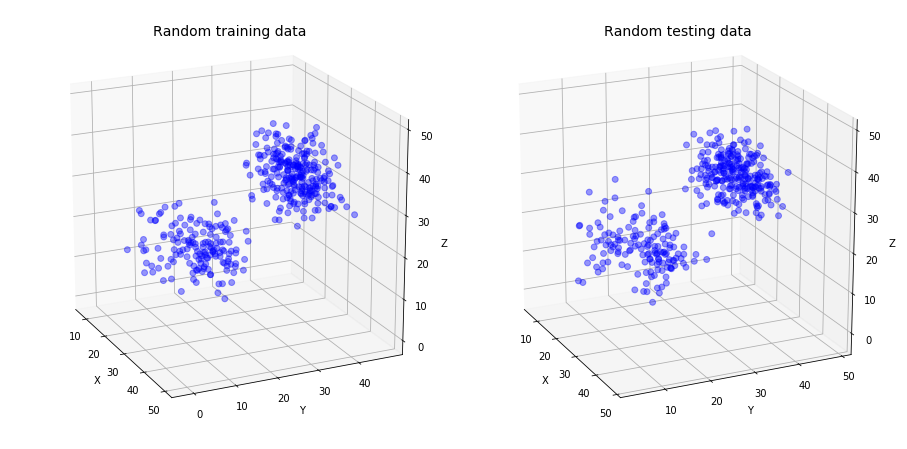

In [0]:
#@markdown - **Распределения обучающих и тестовых данных**
titles = ['Random training data', 'Random testing data']
DATA = [data.sample, data_t.sample]
fig = plt.figure(1, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n in zip([1, 2], titles, DATA):
	ax = fig.add_subplot(1, 2, i, projection='3d')
	ax.scatter(data_n[:,0], data_n[:,1], data_n[:,2], c='b', s=35, alpha=0.4, marker='o')
	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	ax.view_init(elev=20., azim=-25)
	ax.set_title(title, fontsize=14)
plt.show()

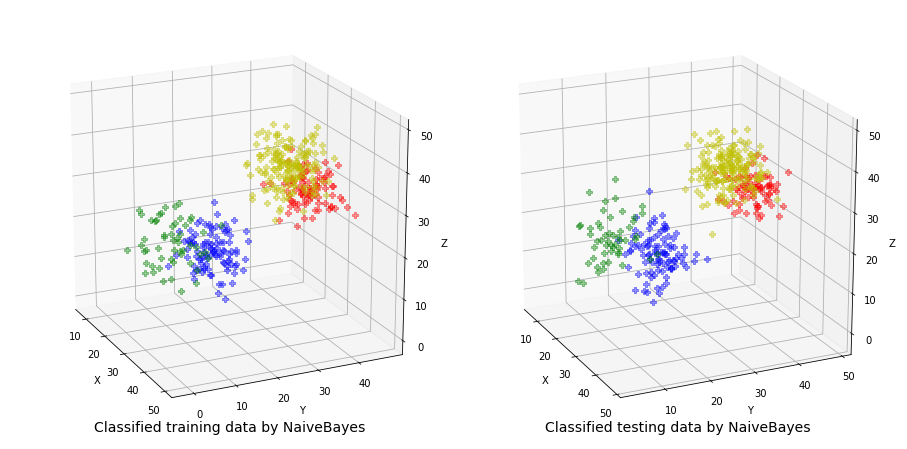

In [0]:
#@markdown - **Представление результата классификации методом наивного байесовского классификатора**
titles = ['Classified training data by NaiveBayes', 'Classified testing data by NaiveBayes']
TAR = [tar_train, tar_test]
fig = plt.figure(2, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n, tar in zip([1, 2], titles, DATA, TAR):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    color=['b','r','g','y']
    for j in range(N):
        ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar[j]], s=35, alpha=0.4, marker='P')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=20., azim=-25)
        ax.set_title(title, fontsize=14, y=0.01)
plt.show()